# Face Recognition

<img src="https://media.lactualite.com/2017/11/lat15_fiap_01-1200x1018.jpg" style="width:350px;height:300px;">
<caption><center> <u> <font color='purple'>  <br> </u> <font color='purple'>

We are going to build a face recognition system. Face recognition problems are divided into one of two categories: 

**Face Verification** "Is this the claimed person?"

**Face Recognition** "Who is this person?" 

In this notebook, we are going to explore them both.

## 1 - Packages

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import PIL

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2 - The model

In Face Verification, we are given two images and we have to determine if they are of the same person. An approach to solve the problem (the simplest way) is to compare the two images pixel-by-pixel. If the distance between the images is below a chosen threshold, it may be the same person!

Of course, this algorithm performs poorly, since the pixel values change dramatically due to variations in lighting, orientation of the person's face, minor changes in head position, and so on.

By using an encoding for each image based on a pretrained model FaceNet, and by comparing those encodings we can have a more accurate decision if the two pictures are of the same person.


### 2.1 - Using FaceNet to Compute Encodings

The FaceNet model takes a lot of data and a long time to train. So, we willl load weights that someone else has already trained , available [here](https://drive.google.com/drive/folders/1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn). 

- This network uses 160x160 dimensional RGB images as its input. 
- The output is a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector

In [10]:
from tensorflow.keras.models import model_from_json

#Uploading the model
json_file = open('keras-facenet-h5/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
FRmodel = model_from_json(loaded_model_json)
FRmodel.load_weights('keras-facenet-h5/model.h5')

Now, let's take a look at the input and output shapes: 

In [11]:
print(FRmodel.inputs)
print(FRmodel.outputs)

[<tf.Tensor 'input_1_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm_1/add_1:0' shape=(None, 128) dtype=float32>]


By using a 128-neuron fully connected layer as its last layer, the model ensures that the output is an encoding vector of size 128. You then use the encodings to compare two face images as follows:

Example:

<img src="images/distance_kiank.png\" style="width:680px;height:250px;">
<caption><center> <u> <font color='purple'> <b>Figure 2:</b> <br> </u> <font color='purple'></center></caption>

- The encodings of two images of the same person are quite similar to each other.
- The encodings of two images of different persons are very different.

FaceNet is trained by minimizing the triplet loss. But since training requires a lot of data and a lot of computation, we will load the previously trained model in the following cell.

## 3 - Face Verification

Here we are building a system for an office building where the building manager would like to offer facial recognition to allow the employees to enter the building.

We wan't to build a face verification system that gives access to a list of people. To be admitted, each person has to swipe an identification card at the entrance. The face recognition system then verifies that they are who they claim to be.

For this model we will have only 12 employees and we can generalze the model for any number of employees.

In [12]:
#Preprocessing the inputs (They must be 160x160)
def img_to_encoding(image_path, model):
    #Setting the shape to the needed one
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    #Normalizing
    img = np.around(np.array(img) / 255.0, decimals=12)
    #Take the shape from (160, 160, 3) to (1, 160, 160, 3) [For Keras training]
    x_train = np.expand_dims(img, axis=0)
    #The vector represnting the image
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [13]:
#Our 12 employees and their images
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)

Load the image of Youness: 

The shape of the image is : (160, 160, 3)


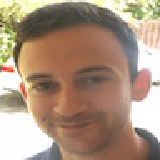

In [16]:
#Testing our function
younes = tf.keras.preprocessing.image.load_img("images/younes.jpg", target_size=(160, 160))
print("The shape of the image is :", np.array(younes).shape)
younes

Now, when someone shows up at your front door and swipes their ID card, you can look up their encoding in the database, and use it to check if the person standing at the front door matches the name on the ID.

In [17]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
        image_path -- path to an image
        identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
        database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
        model -- our Inception model instance in Keras
    
    Returns:
        dist -- distance between the image_path and the image of "identity" in the database.
        door_open -- True, if the door should open. False otherwise.
    """
    # Step 1: Compute the encoding for the image. Use img_to_encoding() see example above.
    encoding = img_to_encoding(image_path, model)
    # Step 2: Compute distance with identity's image
    reference = database[identity]
    dist = np.linalg.norm(encoding-reference)
    # Step 3: Open the door if dist < 0.7, else don't open 
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
    return dist, door_open

Younes is trying to enter the office and the camera takes a picture of him ("images/camera_0.jpg"). Let's run our verification algorithm on this picture:

<img src="images/camera_0.jpg\" style="width:100px;height:100px;">

In [18]:
# TESTING YOUNESS
verify("images/camera_0.jpg", "younes", database, FRmodel)

It's younes, welcome in!


(0.5992949, True)

Benoit, who does not work in the office, stole Kian's ID card and tried to enter the office.The camera took a picture of Benoit ("images/camera_2.jpg). 

Let's run our verification algorithm on this picture:

In [19]:
verify("images/camera_2.jpg", "kian", database, FRmodel)

It's not kian, please go away


(1.0259346, False)

<a name='5-2'></a>
## 4 - Face Recognition

Our face verification system is mostly working. But since Kian got his ID card stolen, when he came back to the office the next day he couldn't get in!

To solve this, the company wan't to change this face verification system to a face recognition system. This way, no one has to carry an ID card anymore. An authorized person can just walk up to the building, and the door will unlock for them!
### 4.1 - Detecting the person in front of the door

In [20]:
# Detect the person in front of the door

def who_is_it(image_path, database, model):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
        image_path -- path to an image
        database -- database containing image encodings along with the name of the person on the image
        model -- our Inception model instance in Keras
    
    Returns:
        min_dist -- the minimum distance between image_path encoding and the encodings from the database
        identity -- string, the name prediction for the person on image_path
    """
    

    ## Step 1: Compute the target "encoding" for the image.
    encoding = img_to_encoding(image_path, model)
    
    ## Step 2: Find the closest encoding ##
    
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current db_enc from the database. (≈ 1 line)
        reference = database[name]
        dist = np.linalg.norm(encoding-reference)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist<min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

Younes is at the front door and the camera takes a picture of him ("images/camera_0.jpg"). Let's see if our `who_it_is()` algorithm identifies Younes.

In [22]:
# Test 1 with Younes pictures 
who_is_it("images/camera_0.jpg", database, FRmodel)


it's younes, the distance is 0.5992949


(0.5992949, 'younes')

**Ways to improve our facial recognition model**:

- Put more images of each person (under different lighting conditions, taken on different days, etc.) into the database. Then, given a new image, compare the new face to multiple pictures of the person. This would increase accuracy.

- Crop the images to contain just the face, and less of the "border" region around the face. This preprocessing removes some of the irrelevant pixels around the face, and also makes the algorithm more robust.